## ZWW workspace -- Boreal Forest Height Part.1 
The notebook is to train Random Forest Regression model for estimating boreal forest height. </br>
The IceSat2 ATL08 product was using as ground truth, bioclim variables, permafrost probability and soil grids were used as predictors. 

Revision:
Read in updated ATL08 raster file.   JL 04/17/2023


In [ ]:
# Import packages
import rioxarray as rxr
import numpy as np
import rasterio as rio
import sys
import xarray as xr
import folium
import pandas as pd
import numpy.ma as ma
import panel as pn
import holoviews as hv


import os

import joblib

#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import train_test_split



# RAPIDS suite for training model with GPU
import cudf
from cuml.model_selection import train_test_split
from cuml import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance



# PyVIZ suite for visualization

import matplotlib.pyplot as plt
import matplotlib
import holoviews.operation.datashader as hd
import panel as pn
import geoviews as gv
gv.extension('bokeh')

In [ ]:
# function to retreive mask of undef values from bioclim variables
def get_bioclim_mask_2d(fn, bnds):
    # undef pixels == True
    ds = rxr.open_rasterio(fn, mask_and_scale=True)
    sub = ds.sel(band=1).rio.clip_box(bnds[0], bnds[1], bnds[2], bnds[3])
    return np.isnan(sub.data).squeeze()

In [ ]:
# function to plot rasterized atl08 data  
def map_atl_raster(fn):
    ds = rxr.open_rasterio(fn, mask_and_scale=True)
    dt = ds.data.squeeze()
    #dt[mask2d] = np.nan

    gv_dataset = gv.Dataset((ds.x.values, ds.y.values, dt), ['lon', 'lat'], 'h_can')
    cls = ['black','#636363','#fc8d59','#fee08b','#ffffbf','#d9ef8b','#91cf60','#1a9850']
    color = matplotlib.colors.LinearSegmentedColormap.from_list(name='myc', colors=cls)

    base_map =  hv.element.tiles.EsriImagery()
    img = gv.Image(gv_dataset).opts(
            height=600, width=1100, colorbar=True, active_tools=['wheel_zoom'],
            tools=['hover'], cmap=color, clim=(0.0, 25.0))
    return hd.regrid(img)

In [ ]:
# function to aggregate training data as a dataframe

#07/07/22 add if statements for not including permafrost and soil data
#04/25/23 include permafrost but not soil grid
def load_training_data(atl_file=None, pf_file=None, bio_path=None):
    df = pd.DataFrame()
    
    print("Loading ATL08 data ...")
    atl_data = rxr.open_rasterio(atl_file, mask_and_scale=True).sel(band=1).values.ravel()
    #atl_data = ds.sel(band=1).values.ravel()
    atl_mask = ~np.isnan(atl_data) & ~np.isinf(atl_data)
    print("Valid ATL08 pts ", atl_mask.sum())
    
    print("Loading Permafrost data ...")
    try:
        pf_data = rxr.open_rasterio(pf_file, mask_and_scale=True).rio.clip_box(minlon, minlat, maxlon, maxlat).sel(band=1).values.ravel()
        pf_mask = ~np.isnan(pf_data)
        print("Valid Permafrost pts ", pf_mask.sum())
    except:
        print('No Permafrost data added')
    
    print("Loading BioClim data ...")
    bio_idx = [str(x).zfill(2) for x in range(1,20)]
    
    #get bioclim mask first
    tmp = os.path.join(bio_path, f"wc2.0_bio_30s_{bio_idx[10]}.tif")
    tmp_data = rxr.open_rasterio(tmp, mask_and_scale=True).rio.clip_box(minlon, minlat, maxlon, maxlat).sel(band=1).values.ravel()
    bio_mask = ~np.isnan(tmp_data)
    print("Valid BioClim pts ", bio_mask.sum())
    
    #With Permafrost; generate total mask
    total_mask = [all(tup) for tup in zip(atl_mask, bio_mask, pf_mask)]
    
    
    total_mask = np.array(total_mask)
    print("Combining ATL08 & Predictors.")
    
    df['h_can'] = atl_data[total_mask]
    print("ATL08 added")
    #Comment out if without Permafrost or Soils 
    df['permafrost'] = pf_data[total_mask]
    print("Permafrost added")
 
    for i, bio in enumerate(bio_idx):
        fn = os.path.join(bio_path, f"wc2.0_bio_30s_{bio}.tif")
        data = rxr.open_rasterio(fn, mask_and_scale=True).rio.clip_box(minlon, minlat, maxlon, maxlat).sel(band=1).values.ravel()
        df[f'bio{bio}'] = data[total_mask]
        print(f"Bioclim_{bio} added")
    
    df = df.fillna(method='ffill', axis=1)
    
    return df

In [ ]:
# Define global variables


#04/17/2023
minlon = -169
maxlon = -50
minlat = 45
maxlat = 75

bbox = [minlon, minlat, maxlon, maxlat]
centre_lon = minlon + (maxlon - minlon)/2.0
centre_lat = minlat + (maxlat - minlat)/2.0
center = [centre_lat, centre_lon]

# bioclim variables and mask
#bio_path = "/efs/STG_Tutorial_Data/BorealHeight_RF/training"
bio_path = "/explore/nobackup/projects/ilab/data/worldclim/1km/bioclim/wc2.0_30s_bio"
bio_idx = [str(x).zfill(2) for x in range(1,20)]
bio_files = [os.path.join(bio_path, f"wc2.0_bio_30s_{i}.tif") for i in bio_idx]
mask2d = get_bioclim_mask_2d(bio_files[0], bbox)

### Show ATL08          


#### Gridding ATL08 to the same spatial resolution as BioClim variables (~1km x 1km)
Offline Pre-Processing : colocating ATL08 points to grid cells, then taking median to reprenst height 
(not included in the demo)


In [ ]:
# Show rasterized ATL08

#fn = '/explore/nobackup/projects/ilab/projects/forest_height/boreal/atl08/atl08_boreal_na_20m_intersect_filt_2018_2022_max_raster.tif'
fn = '/explore/nobackup/projects/ilab/projects/forest_height/boreal/atl08/atl08_boreal_na_20m_intersect_filt_2018_2022_max_wi_zeros.tif'

img = map_atl_raster(fn)
pn.Column(img*gv.tile_sources.EsriImagery)

In [ ]:
#examine distribution of h_can training data
fig, ax = plt.subplots(figsize = (10,10))

atl_data = rxr.open_rasterio(fn, mask_and_scale=True).sel(band=1)
shape = atl_data.shape
atl_data = atl_data.values.ravel()
# make the vector as dataframe, because dataframe can better handle sampling and indices
atl_df = pd.DataFrame(atl_data, columns=['h_can'])

#get quick zonal stats
trainCur = atl_data[~np.isnan(atl_data)]
#trainCur = atl_data
valMax = str(round(np.nanmax(trainCur),3))
valMin = str(round(np.nanmin(trainCur),3))
valMean = str(round(np.nanmean(trainCur),3))
valSTD = str(round(np.nanstd(trainCur),3))

plt.hist(trainCur, bins=60, edgecolor = 'black')
plt.title('ATL08 h_can points (original)')
plt.text(0.8,0.5, f'mean: {valMean}\n STD: {valSTD}\n Min: {valMin}\n Max: {valMax}', fontsize=14, transform = ax.transAxes)

In [ ]:
#Adopted from /efs/jli30/STG/notebooks/proc_atl08_training.ipynb/ (Jian's)
#Reduce zeros and cap values > 30m

## ONE:
## put a 30m cap for 'h_can'
atl_df[atl_df['h_can'] > 30.0]=30.0
atl_df['h_can'].max(), atl_df['h_can'].min()

## Following steps seem unnecessary, because new ATL08 data don't contain large amount of zeros as before.

## Build training dataset

### NOTE : The next cell will take up ~5 minutes to load all training datasets
Alternative approach is to load prepared dataframe instead, to do so, comment out the last line of next cell, and uncomment the cell followed

In [ ]:
%%time
## Note ::

#atl_file = '/efs/zwwillia/BorealHeight_Data/NorthAmerica/atl08_2020_polyFiltered_v2_zeroed.tif'
atl_file = '/explore/nobackup/projects/ilab/projects/forest_height/boreal/atl08/atl08_boreal_na_20m_intersect_filt_2018_2022_max_raster.tif'

#
pf_file = "/explore/nobackup/projects/ilab/projects/forest_height/boreal/layers/UiO_PEX_PERPROB_3.0_20171201_2000_2016_warp_30sec.tif"
#sg_file = "/efs/STG_Tutorial_Data/BorealHeight_RF/training/BDTICM_M_250m_warp_clip.tif"

#pf and sg maps made by Zach for different extents
#pf_file = "/efs/zwwillia/BorealHeight_Data/Global_data/UiO_PEX_PERPROB_3.0_20171201_2000_2016_warp_clip_global.tif"
#sg_file = "/efs/zwwillia/BorealHeight_Data/Global_data/BDTICM_M_250m_warp_clip_global.tif"

bio_path = "/explore/nobackup/projects/ilab/data/worldclim/1km/bioclim/wc2.0_30s_bio"

#remove soil and permafront and look at feature importance
df = load_training_data(atl_file=atl_file, pf_file = pf_file, bio_path=bio_path)

In [ ]:
# df = pd.read_parquet("/efs/STG_Tutorial_Data/BorealHeight_RF/training/full_training.parquet.gzip")

In [ ]:
# Peek at training datasets
df.sample(10)

In [ ]:
## put a 30m cap for 'h_can'
df[df['h_can'] > 30.0]=30.0
df['h_can'].max(), df['h_can'].min()

In [ ]:
# show histogram of forest height in the trainning dataset
bins = list(np.linspace(0, 30, 31))
frequencies, edges = np.histogram(df.h_can.values, bins=bins)
hv.Histogram((edges, frequencies)).opts(height=600, width=1100,tools=['hover'])

## Train model with GPU

In [ ]:
%%time
# transfer data to GPU
data = cudf.from_pandas(df)
data = data.astype(np.float32)

In [ ]:
## split training/testing at 80/20 ratio
test_ratio = 0.2
df_train, df_test = train_test_split(data, test_size=test_ratio, random_state=43)
label_name = 'h_can'
X_train, y_train = df_train.drop(label_name, axis=1), df_train[label_name]
X_test, y_test = df_test.drop(label_name, axis=1), df_test[label_name]

In [ ]:
%%time
regr = RandomForestRegressor(n_estimators=100, bootstrap=False, random_state=42)
regr.fit(X_train, y_train)

In [ ]:
# calculate r^2 score of the regression model
pred_train = regr.predict(X_train)
r2_train = np.round(r2_score(y_train.to_numpy(), pred_train.to_numpy()), 2)
print(f"The R^2 score for training is: {r2_train}")

pred_test = regr.predict(X_test)
r2_test = np.round(r2_score(y_test.to_numpy(), pred_test.to_numpy()), 2)
print(f"The R^2 score for testing is: {r2_test}")

In [ ]:
#### Save the trained model for furture usage.
fout = "/explore/nobackup/projects/ilab/projects/forest_height/boreal/rf_model/rf_NA_ATL_max_Perm.joblib"
joblib.dump(regr, fout)

## Ranked Permutation Importances

In [ ]:
permutation_importance_results = permutation_importance(regr,
X=X_test,
y=y_test,
n_repeats=5,
random_state=42)

sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(10, 10))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

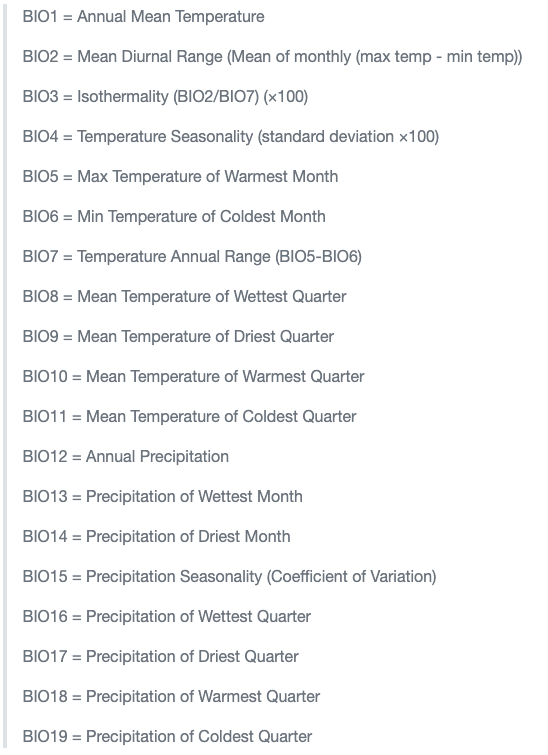